In [1]:
#Import Libraries for clustering and time series analysis
from pandas_datareader import data as pdr
from datetime import date
import datetime
import yfinance as yf
yf.pdr_override()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from fbprophet import Prophet
from random import random
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

In [2]:
# Initialize a list with all the required stocks 
# Stocks data between given dates are extracted
today = date.today()
ticker_list=['DJIA','SPY', 'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'AMZN', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'SLB', 'KHC', 'MT', 'HAL', 'XEC', 'PHI', 'ADS', 'M', 'GPRO', 'HTZGQ','MUR', 'MOS', 'DVN', 'MRO', 'FLR', 'INTC', 'CTSH', 'T']
start_date=datetime.datetime.strptime('2010-01-01','%Y-%m-%d')
end_date=datetime.datetime.strptime('2018-12-31','%Y-%m-%d')


In [3]:
#Function to get Data from Yahoo Finance
stock_df = pd.DataFrame()  #New dataframe

def getData(ticker):
    print (ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    data['ticker'] = ticker
    global stock_df  # use global df
    stock_df = stock_df.append(data) #append to the global df
for tik in ticker_list:
    getData(tik)
stock_df.reset_index(inplace=True)  #reset index

DJIA
[*********************100%***********************]  1 of 1 completed
SPY
[*********************100%***********************]  1 of 1 completed
MMM
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
AMGN
[*********************100%***********************]  1 of 1 completed
AAPL
[*********************100%***********************]  1 of 1 completed
BA
[*********************100%***********************]  1 of 1 completed
CAT
[*********************100%***********************]  1 of 1 completed
CVX
[*********************100%***********************]  1 of 1 completed
CSCO
[*********************100%***********************]  1 of 1 completed
KO
[*********************100%***********************]  1 of 1 completed
AMZN
[*********************100%***********************]  1 of 1 completed
GS
[*********************100%***********************]  1 of 1 completed
HD
[*********************100%********************

In [4]:
stock_df.to_csv('stock.csv', index=False)
stock_df

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2010-01-04,10430.690430,10641.620117,10430.690430,10583.959961,10583.959961,3991400000,DJIA
1,2010-01-05,10584.559570,10647.139648,10468.860352,10572.019531,10572.019531,2491020000,DJIA
2,2010-01-06,10564.719727,10655.219727,10488.280273,10573.679688,10573.679688,4972660000,DJIA
3,2010-01-07,10571.110352,10655.599609,10471.730469,10606.860352,10606.860352,5270680000,DJIA
4,2010-01-08,10606.400391,10653.110352,10509.740234,10618.190430,10618.190430,4389590000,DJIA
...,...,...,...,...,...,...,...,...
108999,2018-12-21,28.340000,29.240000,28.139999,28.309999,24.083691,79660700,T
109000,2018-12-24,28.209999,28.290001,27.360001,27.360001,23.275515,41110100,T
109001,2018-12-26,27.500000,28.100000,26.799999,28.080000,23.888027,57391200,T
109002,2018-12-27,27.809999,28.160000,27.170000,28.150000,23.947577,58571200,T


In [5]:
#Function to get Actuals Data from Yahoo Finance
Actuals_df = pd.DataFrame()  #New dataframe
start_date_Actuals=datetime.datetime.strptime('2019-01-01','%Y-%m-%d')
end_date_Actuals=datetime.datetime.strptime('2019-12-31','%Y-%m-%d')
def getDataActuals(ticker):
    print (ticker)
    data = pdr.get_data_yahoo(ticker, start=start_date_Actuals, end=end_date_Actuals)
    data['ticker'] = ticker
    global Actuals_df  # use global df
    Actuals_df = Actuals_df.append(data) #append to the global df
#Actuals_df.reset_index(inplace=True)  #reset index

In [6]:
#Function to predict Stock price using ARIMA
def make_predictions(train_data, test_data,n_test, p, d, q, P=0, D=0, Q=0, s=0):
    train = train_data.values.tolist()
    test = test_data.values.tolist()
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(train, order = (p, d, q), seasonal_order = (P, D, Q, s))
        fitted_model = model.fit()
        predicted = fitted_model.forecast()
        predictions.append(predicted[-1])
        train.append(test[t])
    # Evaluate predictions
    error = mean_squared_error(test, predictions)
    corr = np.corrcoef(test, predictions)[1, 0]
    print('MSE: %.3f' % error)
    print('Correlation: %.3f' % corr)
    # Plot results
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.xlabel('Days')
    plt.ylabel('Stock Price')
    plt.show()

# Time Series analysis

### FB Prophet model : Compare actuals data vs predictions for different stocks

In [7]:
Disney_df = stock_df.loc[stock_df["ticker"] == 'DIS']
Disney_df = Disney_df[['Date', 'Open']]
Disney_df.columns = ['ds', 'y']
model = Prophet(interval_width=0.95, growth='linear', changepoints=None,
               seasonality_mode='additive', yearly_seasonality=True,
               weekly_seasonality=True, daily_seasonality=True, holidays=None) # the Prophet class (model)
model.fit(Disney_df) # fit the model using all data

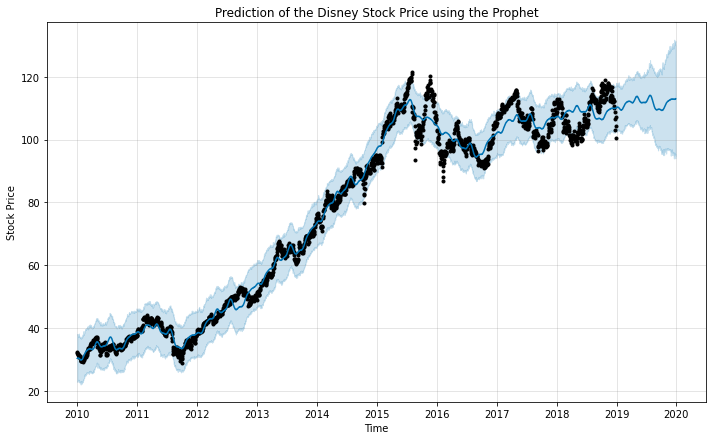

In [8]:
#Future prediction for a year
future = model.make_future_dataframe(periods=365)
mask = (future['ds'].dt.dayofweek < 5)
prediction = model.predict(future.loc[mask])
#prediction.to_csv('test/t_15min_0.95_06_26_2020.csv')
model.plot(prediction)
plt.title("Prediction of the Disney Stock Price using the Prophet")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

In [9]:
#Predicted Values
prediction 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,31.969983,22.892050,37.497772,31.969983,31.969983,-1.599689,-1.599689,-1.599689,-1.650156,...,-0.079817,-0.079817,-0.079817,0.130284,0.130284,0.130284,0.0,0.0,0.0,30.370294
1,2010-01-05,31.992869,22.858214,38.175471,31.992869,31.992869,-1.545536,-1.545536,-1.545536,-1.650156,...,-0.034801,-0.034801,-0.034801,0.139421,0.139421,0.139421,0.0,0.0,0.0,30.447334
2,2010-01-06,32.015756,23.138286,37.803572,32.015756,32.015756,-1.617212,-1.617212,-1.617212,-1.650156,...,-0.109703,-0.109703,-0.109703,0.142646,0.142646,0.142646,0.0,0.0,0.0,30.398544
3,2010-01-07,32.038642,23.045916,37.985383,32.038642,32.038642,-1.622622,-1.622622,-1.622622,-1.650156,...,-0.111774,-0.111774,-0.111774,0.139308,0.139308,0.139308,0.0,0.0,0.0,30.416020
4,2010-01-08,32.061529,23.491044,37.674812,32.061529,32.061529,-1.597713,-1.597713,-1.597713,-1.650156,...,-0.076444,-0.076444,-0.076444,0.128887,0.128887,0.128887,0.0,0.0,0.0,30.463815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2019-12-23,114.764951,95.145624,131.461420,98.097077,131.370486,-1.859559,-1.859559,-1.859559,-1.650156,...,-0.079817,-0.079817,-0.079817,-0.129586,-0.129586,-0.129586,0.0,0.0,0.0,112.905392
2519,2019-12-24,114.773001,95.527164,131.089279,98.018622,131.426534,-1.803333,-1.803333,-1.803333,-1.650156,...,-0.034801,-0.034801,-0.034801,-0.118376,-0.118376,-0.118376,0.0,0.0,0.0,112.969669
2520,2019-12-25,114.781052,94.030540,131.484862,97.940340,131.482583,-1.863213,-1.863213,-1.863213,-1.650156,...,-0.109703,-0.109703,-0.109703,-0.103355,-0.103355,-0.103355,0.0,0.0,0.0,112.917838
2521,2019-12-26,114.789102,95.263943,130.629180,97.854191,131.538631,-1.846811,-1.846811,-1.846811,-1.650156,...,-0.111774,-0.111774,-0.111774,-0.084881,-0.084881,-0.084881,0.0,0.0,0.0,112.942291


In [10]:
#Get actuals data for Disney
getDataActuals('DIS')
Disney_Actuals = Actuals_df.loc[Actuals_df["ticker"] == 'DIS']
Disney_Actuals.reset_index(inplace=True)  #reset index


DIS
[*********************100%***********************]  1 of 1 completed


In [11]:
print(Disney_Actuals)

          Date        Open        High         Low       Close   Adj Close  \
0   2019-01-02  108.099998  109.139999  107.730003  108.970001  107.654343   
1   2019-01-03  108.480003  108.650002  105.940002  106.330002  105.046211   
2   2019-01-04  107.940002  110.750000  107.250000  109.610001  108.286606   
3   2019-01-07  109.910004  111.400002  109.300003  110.559998  109.225136   
4   2019-01-08  111.800003  112.559998  111.169998  111.419998  110.074753   
..         ...         ...         ...         ...         ...         ...   
246 2019-12-23  145.910004  146.330002  144.330002  144.679993  144.679993   
247 2019-12-24  144.580002  145.429993  144.449997  145.289993  145.289993   
248 2019-12-26  145.399994  145.860001  145.169998  145.699997  145.699997   
249 2019-12-27  146.050003  146.509995  145.449997  145.750000  145.750000   
250 2019-12-30  145.750000  145.869995  143.399994  143.770004  143.770004   

       Volume ticker  
0     9723500    DIS  
1    10594700    

Text(0, 0.5, 'Stock Price')

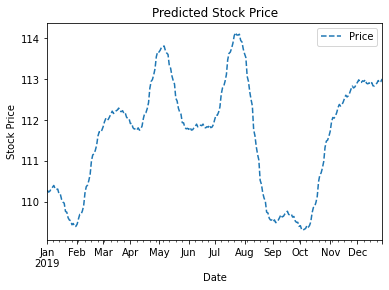

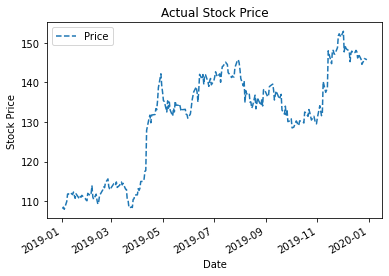

In [12]:
prediction = prediction.rename(columns={'ds': 'Date', 'yhat':'Price'})
Disney_df_predict = prediction[prediction['Date'] > '2018-12-31'][["Date","Price"]]
ax1 = Disney_df_predict.plot(x='Date', y='Price', style='--', title='Predicted Stock Price')
Disney_Actuals = Disney_Actuals[['Date','Open']]
Disney_Actuals = Disney_Actuals.rename(columns={'Open':'Price'})
ax2 = Disney_Actuals.plot(x='Date', y='Price', style='--',title='Actual Stock Price')
prediction.to_csv('stock_Disney.csv', index=False)
ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Stock Price")

In [13]:
Disney_df = Disney_df['y']
Disney_df =  Disney_df.squeeze()
Disney_Actuals = Disney_Actuals['Price']
Disney_Actuals = Disney_Actuals.squeeze()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 2263
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3202.962
Date:                          Sat, 24 Apr 2021   AIC                           6415.925
Time:                                  19:05:54   BIC                           6444.518
Sample:                                       0   HQIC                          6426.361
                                         - 2263                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7512      0.199      3.781      0.000       0.362       1.141
ma.L1         -0.7755      0.190     -4.075      0.

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Usin

MSE: 3.419
Correlation: 0.990


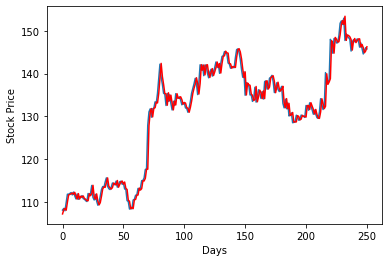

In [14]:
# Fit model
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
model = ARIMA(Disney_df, order = (p, d, q), seasonal_order = (P, D, Q, s))
fitted_model = model.fit()
print(fitted_model.summary())

# Make predictions
n_test = 365 # Number of observations for test
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
make_predictions(Disney_df, Disney_Actuals, n_test, p, d, q, P, D, Q, s)

In [15]:
T_df = stock_df.loc[stock_df["ticker"] == 'T']
T_df = T_df[['Date', 'Open']]
T_df.columns = ['ds', 'y']
model = Prophet(interval_width=0.95, growth='flat', changepoints=None,
               seasonality_mode='additive', yearly_seasonality=True,
               weekly_seasonality=False, daily_seasonality=False, holidays=None) # the Prophet class (model)
model.fit(T_df) # fit the model using all data

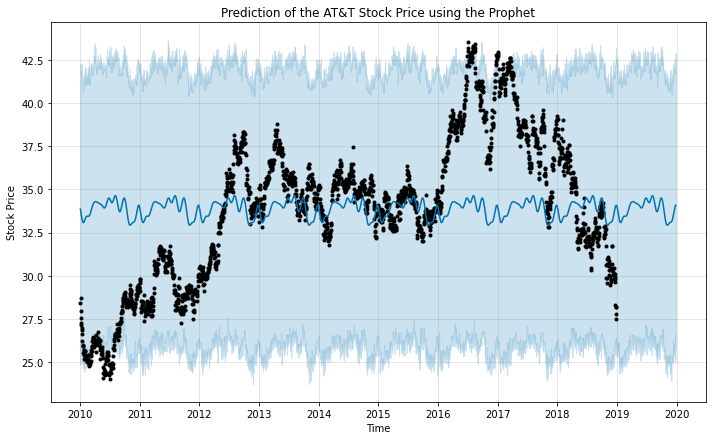

In [16]:
future = model.make_future_dataframe(periods=365)
mask = (future['ds'].dt.dayofweek < 5)
prediction = model.predict(future.loc[mask])
#prediction.to_csv('test/t_15min_0.95_06_26_2020.csv')
model.plot(prediction)
plt.title("Prediction of the AT&T Stock Price using the Prophet")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

In [17]:
#Get actuals data for AT&T
getDataActuals('T')
T_Actuals = Actuals_df.loc[Actuals_df["ticker"] == 'T']
T_Actuals.reset_index(inplace=True)  #reset index


T
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Stock Price')

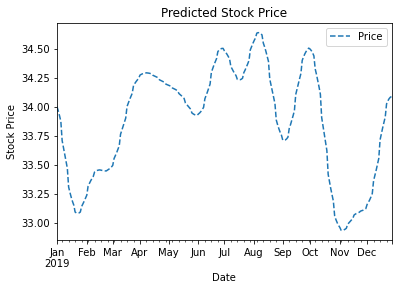

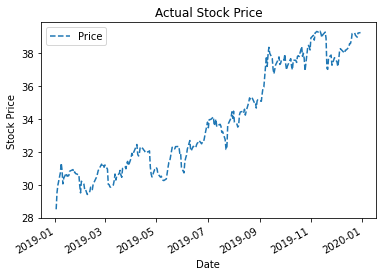

In [18]:
prediction = prediction.rename(columns={'ds': 'Date', 'yhat':'Price'})
T_df_predict = prediction[prediction['Date'] > '2018-12-31'][["Date","Price"]]
ax1 = T_df_predict.plot(x='Date', y='Price', style='--', title='Predicted Stock Price')
T_Actuals = T_Actuals[['Date','Open']]
T_Actuals = T_Actuals.rename(columns={'Open':'Price'})
ax2 = T_Actuals.plot(x='Date', y='Price', style='--',title='Actual Stock Price')
prediction.to_csv('stock_AT&T.csv', index=False)
ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Stock Price")

In [19]:
T_df = T_df['y']
T_df =  T_df.squeeze()
T_Actuals = T_Actuals['Price']
T_Actuals = T_Actuals.squeeze()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 2263
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -873.801
Date:                          Sat, 24 Apr 2021   AIC                           1757.602
Time:                                  19:38:32   BIC                           1786.196
Sample:                                       0   HQIC                          1768.039
                                         - 2263                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3202      1.060     -0.302      0.763      -2.398       1.758
ma.L1          0.3052      1.064      0.287      0.

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

MSE: 0.153
Correlation: 0.993


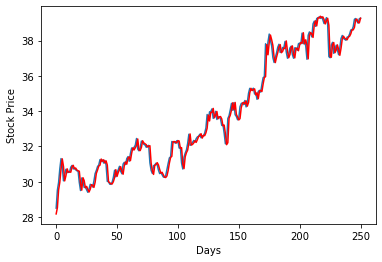

In [20]:
# Fit model
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
model = ARIMA(T_df, order = (p, d, q), seasonal_order = (P, D, Q, s))
fitted_model = model.fit()
print(fitted_model.summary())

# Make predictions
n_test = 365 # Number of observations for test
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
make_predictions(T_df, T_Actuals, n_test, p, d, q, P, D, Q, s)

In [21]:
MSFT_df = stock_df.loc[stock_df["ticker"] == 'MSFT']
MSFT_df = MSFT_df[['Date', 'Open']]
MSFT_df.columns = ['ds', 'y']
model = Prophet(interval_width=0.95, growth='linear', changepoints=None,
               seasonality_mode='additive', yearly_seasonality=True,
               weekly_seasonality=True, daily_seasonality=True, holidays=None) # the Prophet class (model)
model.fit(MSFT_df) # fit the model using all data

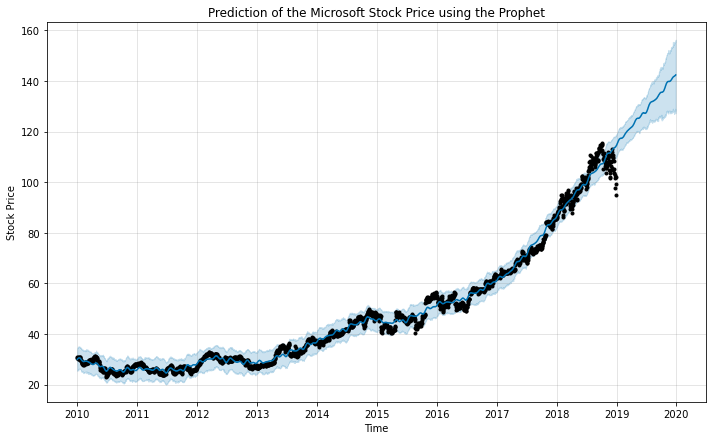

In [22]:
future = model.make_future_dataframe(periods=365)
mask = (future['ds'].dt.dayofweek < 5)
prediction = model.predict(future.loc[mask])
#prediction.to_csv('test/t_15min_0.95_06_26_2020.csv')
model.plot(prediction)
plt.title("Prediction of the Microsoft Stock Price using the Prophet")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

In [23]:
prediction 

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,30.369800,25.466264,34.092467,30.369800,30.369800,-0.393599,-0.393599,-0.393599,-0.390761,...,-0.029040,-0.029040,-0.029040,0.026202,0.026202,0.026202,0.0,0.0,0.0,29.976202
1,2010-01-05,30.350847,25.849273,34.568160,30.350847,30.350847,-0.297309,-0.297309,-0.297309,-0.390761,...,-0.012479,-0.012479,-0.012479,0.105931,0.105931,0.105931,0.0,0.0,0.0,30.053538
2,2010-01-06,30.331893,25.826864,34.558269,30.331893,30.331893,-0.235204,-0.235204,-0.235204,-0.390761,...,-0.033880,-0.033880,-0.033880,0.189436,0.189436,0.189436,0.0,0.0,0.0,30.096689
3,2010-01-07,30.312940,25.864780,34.820827,30.312940,30.312940,-0.160945,-0.160945,-0.160945,-0.390761,...,-0.045289,-0.045289,-0.045289,0.275104,0.275104,0.275104,0.0,0.0,0.0,30.151994
4,2010-01-08,30.293986,25.887045,34.668358,30.293986,30.293986,-0.006521,-0.006521,-0.006521,-0.390761,...,0.022997,0.022997,0.022997,0.361243,0.361243,0.361243,0.0,0.0,0.0,30.287466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2019-12-23,142.804114,127.459149,155.533532,129.331413,155.372607,-0.704358,-0.704358,-0.704358,-0.390761,...,-0.029040,-0.029040,-0.029040,-0.284557,-0.284557,-0.284557,0.0,0.0,0.0,142.099756
2519,2019-12-24,142.881625,129.048553,155.543774,129.334500,155.515921,-0.712293,-0.712293,-0.712293,-0.390761,...,-0.012479,-0.012479,-0.012479,-0.309053,-0.309053,-0.309053,0.0,0.0,0.0,142.169332
2520,2019-12-25,142.959135,127.165057,155.808951,129.337587,155.659235,-0.751644,-0.751644,-0.751644,-0.390761,...,-0.033880,-0.033880,-0.033880,-0.327004,-0.327004,-0.327004,0.0,0.0,0.0,142.207491
2521,2019-12-26,143.036646,128.254207,155.410106,129.340675,155.802550,-0.773359,-0.773359,-0.773359,-0.390761,...,-0.045289,-0.045289,-0.045289,-0.337309,-0.337309,-0.337309,0.0,0.0,0.0,142.263287


In [24]:
#Get actuals data for Microsoft
getDataActuals('MSFT')
MSFT_Actuals = Actuals_df.loc[Actuals_df["ticker"] == 'MSFT']
MSFT_Actuals.reset_index(inplace=True)  #reset index


MSFT
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Stock Price')

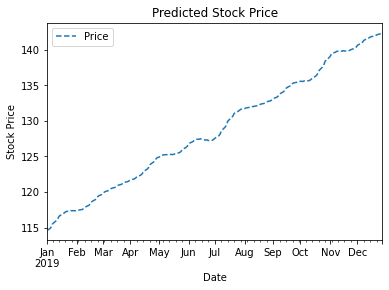

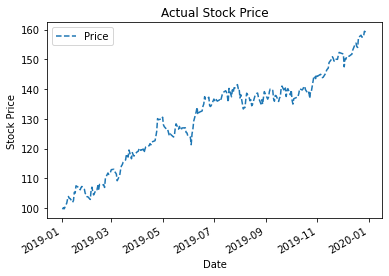

In [25]:
prediction = prediction.rename(columns={'ds': 'Date', 'yhat':'Price'})
MSFT_df_predict = prediction[prediction['Date'] > '2018-12-31'][["Date","Price"]]
ax1 = MSFT_df_predict.plot(x='Date', y='Price', style='--', title='Predicted Stock Price')
MSFT_Actuals = MSFT_Actuals[['Date','Open']]
MSFT_Actuals = MSFT_Actuals.rename(columns={'Open':'Price'})
ax2 = MSFT_Actuals.plot(x='Date', y='Price', style='--',title='Actual Stock Price')
prediction.to_csv('stock_Microsoft.csv', index=False)
ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Stock Price")

In [26]:
MSFT_df = MSFT_df['y']
MSFT_df =  MSFT_df.squeeze()
MSFT_Actuals = MSFT_Actuals['Price']
MSFT_Actuals = MSFT_Actuals.squeeze()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                 2263
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2686.309
Date:                          Sat, 24 Apr 2021   AIC                           5382.617
Time:                                  20:08:39   BIC                           5411.211
Sample:                                       0   HQIC                          5393.054
                                         - 2263                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1122      0.098      1.147      0.251      -0.080       0.304
ma.L1         -0.2277      0.096     -2.363      0.

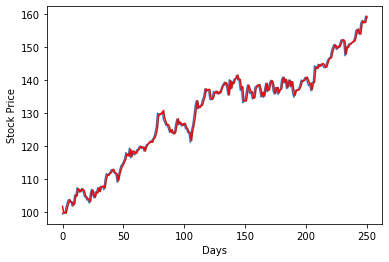

In [27]:
# Fit model
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
model = ARIMA(MSFT_df, order = (p, d, q), seasonal_order = (P, D, Q, s))
fitted_model = model.fit()
print(fitted_model.summary())

# Make predictions
n_test = 365 # Number of observations for test
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
make_predictions(MSFT_df, MSFT_Actuals, n_test, p, d, q, P, D, Q, s)

In [28]:
KHC_df = stock_df.loc[stock_df["ticker"] == 'KHC']
KHC_df = KHC_df[['Date', 'Open']]
KHC_df.columns = ['ds', 'y']
model = Prophet(interval_width=0.95, growth='linear', changepoints=None,
               seasonality_mode='additive', yearly_seasonality=True,
               weekly_seasonality=True, daily_seasonality=True, holidays=None) # the Prophet class (model)
model.fit(KHC_df) # fit the model using all data

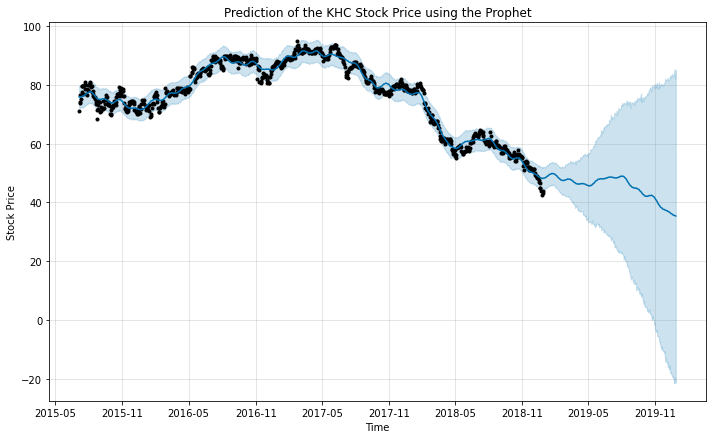

In [30]:
future = model.make_future_dataframe(periods=365)
mask = (future['ds'].dt.dayofweek < 5)
prediction = model.predict(future.loc[mask])
#prediction.to_csv('test/t_15min_0.95_06_26_2020.csv')
model.plot(prediction)
plt.title("Prediction of the KHC Stock Price using the Prophet")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()

In [31]:
#Get actuals data for KHC
getDataActuals('KHC')
KHC_Actuals = Actuals_df.loc[Actuals_df["ticker"] == 'KHC']
KHC_Actuals.reset_index(inplace=True)  #reset index

KHC
[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Stock Price')

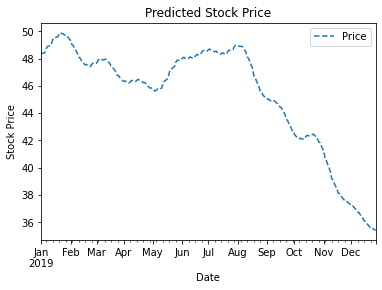

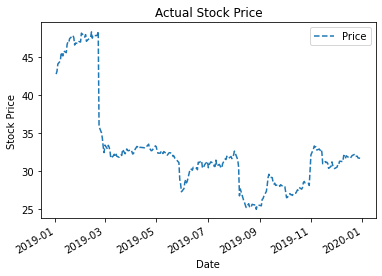

In [32]:
prediction = prediction.rename(columns={'ds': 'Date', 'yhat':'Price'})
KHC_df_predict = prediction[prediction['Date'] > '2018-12-31'][["Date","Price"]]
ax1 = KHC_df_predict.plot(x='Date', y='Price', style='--', title='Predicted Stock Price')
KHC_Actuals = KHC_Actuals[['Date','Open']]
KHC_Actuals = KHC_Actuals.rename(columns={'Open':'Price'})
ax2 = KHC_Actuals.plot(x='Date', y='Price', style='--',title='Actual Stock Price')
prediction.to_csv('stock_KHC.csv', index=False)
ax1.set_ylabel("Stock Price")
ax2.set_ylabel("Stock Price")

In [33]:
KHC_df = KHC_df['y']
KHC_df =  KHC_df.squeeze()
KHC_Actuals = KHC_Actuals['Price']
KHC_Actuals = KHC_Actuals.squeeze()

C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  879
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1276.798
Date:                          Sat, 24 Apr 2021   AIC                           2563.596
Time:                                  23:21:04   BIC                           2587.415
Sample:                                       0   HQIC                          2572.712
                                          - 879                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4610      0.347      1.330      0.183      -0.218       1.140
ma.L1         -0.5236      0.335     -1.565      0.

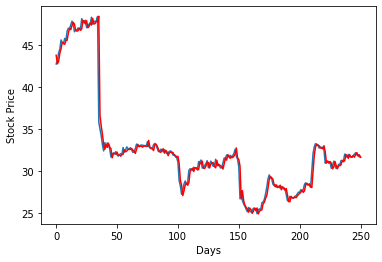

In [34]:
# Fit model
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
model = ARIMA(KHC_df, order = (p, d, q), seasonal_order = (P, D, Q, s))
fitted_model = model.fit()
print(fitted_model.summary())

# Make predictions
n_test = 253 # Number of observations for test
p, d, q, P, D, Q, s = 1, 1, 1, 1, 1, 1, 12 # Parameters of SARIMA model
make_predictions(KHC_df, KHC_Actuals, n_test, p, d, q, P, D, Q, s)

### Data Preparation for Clustering

In [35]:
# convert long format to wide sing pivot table
stock_df_annual = stock_df[['Date', 'Adj Close', 'ticker']]

stock_df_annual = pd.pivot_table(stock_df_annual, columns = 'ticker', values = 'Adj Close', index = ['Date']).reset_index()

stock_df_annual


ticker,Date,AAPL,ADS,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,...,SLB,SPY,T,TRV,UNH,V,VZ,WBA,WMT,XEC
0,2010-01-04,6.583586,61.933838,45.675011,133.899994,34.405621,43.777542,42.787361,18.705000,18.332541,...,50.744717,90.790062,14.933931,37.927544,26.591478,20.339539,18.162601,28.326071,41.442036,50.166107
1,2010-01-05,6.594968,62.056046,45.279354,134.690002,34.329956,45.211330,43.298920,18.625000,18.250862,...,50.888378,91.030411,14.860781,37.029022,26.549313,20.106466,18.195339,28.098249,41.029366,50.075184
2,2010-01-06,6.490066,62.366211,44.939075,132.250000,34.884884,46.582798,43.430443,18.592501,18.132059,...,52.022587,91.094490,14.643327,36.503632,26.810753,19.836475,17.672155,27.885616,40.937664,50.002426
3,2010-01-07,6.478067,62.939594,44.527592,130.000000,35.450680,48.468555,43.605824,18.510000,18.213734,...,52.559433,91.479050,14.478918,37.029022,27.839664,20.021082,17.566957,28.052691,40.960583,49.211334
4,2010-01-08,6.521136,63.616360,44.923252,133.520004,35.425346,48.001007,44.095455,18.537500,18.310261,...,53.421459,91.783432,14.372847,36.975742,27.578215,20.076460,17.578037,28.090660,40.754265,50.129742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,2018-12-21,36.751911,143.193115,168.931290,1377.449951,87.858299,295.930267,112.238724,122.910004,38.753490,...,32.501633,231.139191,24.083691,110.411888,229.765305,122.522209,49.415497,61.856220,83.648956,57.542274
2259,2018-12-24,35.800995,138.774155,167.234589,1343.959961,86.097862,285.834320,109.322212,121.330002,37.299660,...,32.037323,225.031799,23.275515,107.148804,224.559586,120.027588,47.732922,60.016895,82.391281,54.644184
2260,2018-12-26,38.322155,145.709976,176.102509,1470.900024,90.272888,305.044769,116.622841,130.839996,39.327625,...,33.330101,236.401520,23.888027,111.467865,234.595078,128.408707,48.983608,62.279259,86.797920,59.096180
2261,2018-12-27,38.073456,145.911713,178.417938,1461.640015,91.080956,308.163910,118.408264,135.199997,39.735069,...,33.075188,238.216446,23.947577,112.894875,237.120819,130.163818,49.622452,62.867844,87.930763,59.086643


In [36]:
# calculate annual returns value for each stock by year
stock_df_annual = stock_df_annual.set_index('Date').iloc[:,:].resample('Y').last().pct_change()
stock_df_annual.reset_index(inplace = True)
stock_df_annual

ticker,Date,AAPL,ADS,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,...,SLB,SPY,T,TRV,UNH,V,VZ,WBA,WMT,XEC
0,2010-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-31,0.255580,0.461918,0.181733,-0.038333,0.116577,0.151470,-0.014528,-0.231364,-0.096172,...,-0.171569,0.018950,0.090239,0.093100,0.421891,0.454081,0.181920,-0.133464,0.138448,-0.297378
2,2012-12-31,0.325669,0.394068,0.368309,0.449278,0.235846,0.052178,0.015952,0.656811,0.116055,...,0.030059,0.159903,0.174877,0.248512,0.086026,0.504670,0.131762,0.152734,0.169890,-0.060569
3,2013-12-31,0.080695,0.816317,0.347965,0.589628,0.598358,0.847228,0.034204,0.313266,0.167266,...,0.320639,0.323078,0.097221,0.290864,0.410431,0.480564,0.186029,0.589405,0.181637,0.829877
4,2014-12-31,0.406225,0.087932,0.423333,-0.221771,0.036627,-0.025465,0.034765,0.074651,0.279758,...,-0.036297,0.134638,0.006594,0.196117,0.364561,0.186358,-0.005476,0.353361,0.118709,0.015571
5,2015-12-31,-0.030137,-0.033141,0.039554,1.177831,-0.242095,0.140651,-0.229737,0.321868,0.006195,...,-0.163158,0.012343,0.083198,0.090957,0.182713,0.191374,0.036198,0.136160,-0.266366,-0.152040
6,2016-12-31,0.124804,-0.171702,-0.075560,0.109456,0.085822,0.113088,0.421059,-0.126786,0.151337,...,0.235267,0.119979,0.298744,0.109709,0.384083,0.013712,0.206995,-0.010127,0.160312,0.526462
7,2017-12-31,0.484643,0.119188,0.222682,0.559564,0.362163,0.947151,0.750336,0.493281,0.312683,...,-0.173692,0.217054,-0.040058,0.133582,0.398350,0.471765,0.039755,-0.105113,0.465607,-0.099736
8,2018-12-31,-0.062959,-0.402790,0.129008,0.263838,-0.035396,0.093857,-0.185053,0.317421,0.150650,...,-0.438613,-0.053976,-0.224700,-0.107839,0.132000,0.156047,0.093777,-0.040453,-0.044894,-0.494764


In [37]:
#Convert wide format to long with annual returns value in one column
stock_df_annual = pd.melt(stock_df_annual, id_vars = ['Date'],  var_name='stock', value_name ='annual_returns')
stock_df_annual


,Date,stock,annual_returns
0,2010-12-31,AAPL,NaN
1,2011-12-31,AAPL,0.255580
2,2012-12-31,AAPL,0.325669
3,2013-12-31,AAPL,0.080695
4,2014-12-31,AAPL,0.406225
...,...,...,...
436,2014-12-31,XEC,0.015571
437,2015-12-31,XEC,-0.152040
438,2016-12-31,XEC,0.526462
439,2017-12-31,XEC,-0.099736


In [38]:
#drop NA values

stock_df_annual = stock_df_annual.dropna()

#Convert values to percent
stock_df_annual['annual_returns'] = stock_df_annual['annual_returns'] * 100

stock_df_annual

<ipython-input-38-0ca82028ab0c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_annual['annual_returns'] = stock_df_annual['annual_returns'] * 100


,Date,stock,annual_returns
1,2011-12-31,AAPL,25.558034
2,2012-12-31,AAPL,32.566878
3,2013-12-31,AAPL,8.069519
4,2014-12-31,AAPL,40.622499
5,2015-12-31,AAPL,-3.013713
...,...,...,...
436,2014-12-31,XEC,1.557095
437,2015-12-31,XEC,-15.204028
438,2016-12-31,XEC,52.646156
439,2017-12-31,XEC,-9.973568


# Clustering

In [39]:
# Standardize all data without splitting into training and validation
# CLUSTERING
scaler = StandardScaler()
scaler.fit(stock_df_annual['annual_returns'].values.reshape(-1,1))
x_scaled_annual = scaler.transform(stock_df_annual['annual_returns'].values.reshape(-1,1) )
x_scaled_annual

array([[ 0.57739453],
       [ 0.84498278],
       [-0.09029343],
       [ 1.15253553],
       [-0.51343631],
       [ 0.07810917],
       [ 1.45192515],
       [-0.63874403],
       [ 1.36516286],
       [ 1.10612027],
       [ 2.71821114],
       [-0.06266329],
       [-0.52490396],
       [-1.05391006],
       [ 0.05666833],
       [-1.93617493],
       [ 0.29545694],
       [ 1.00777632],
       [ 0.9301084 ],
       [ 1.21785116],
       [-0.24736393],
       [-0.68685419],
       [ 0.45179397],
       [ 0.09415956],
       [-0.54472819],
       [ 1.31690535],
       [ 1.85274416],
       [-1.24506811],
       [ 4.0984253 ],
       [ 0.01951013],
       [ 1.73796182],
       [ 0.60891931],
       [ 0.04669862],
       [ 0.50205288],
       [ 1.88607402],
       [-0.25854075],
       [-1.32266125],
       [-0.07071818],
       [ 0.98431405],
       [-0.53351513],
       [ 0.17991682],
       [-0.19916991],
       [ 2.8362273 ],
       [-0.4956005 ],
       [ 0.13861035],
       [ 0

## K-Means

### Single iteration

In [40]:
# CLUSTERING: K-Means clustering (random initialization, single iteration and number of clusters = 3)
clustering = KMeans(n_clusters = 3, init = 'random', n_init = 1).fit(x_scaled_annual)
clusters = clustering.labels_
centers = clustering.cluster_centers_
print(clusters)
print(centers)

[0 1 0 1 0 0 1 0 1 1 1 0 0 2 0 2 0 1 1 1 0 2 0 0 0 1 1 2 1 0 1 0 0 0 1 0 2
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 2 1 1 2 2 1 1 0 1 2 1 1 2 0 0 1 0 0 1 0 2 0
 1 0 0 0 1 2 0 0 0 0 2 1 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 2 1 2
 2 2 0 1 2 2 0 0 2 2 2 2 2 2 1 1 0 0 1 0 2 2 0 1 2 2 1 2 2 0 1 1 1 1 0 1 2
 0 0 1 0 0 0 1 2 0 2 1 0 0 2 2 0 0 2 0 2 1 1 0 0 1 0 0 0 1 0 0 0 0 0 2 1 1
 0 0 1 0 0 0 2 2 0 0 0 0 0 0 0 0 1 0 1 0 2 0 2 0 1 2 0 0 1 0 1 0 0 0 1 0 0
 0 1 2 2 0 2 0 2 0 2 0 0 0 0 0 0 0 0 1 1 0 0 2 2 1 0 2 0 0 1 1 0 0 1 0 2 0
 0 2 2 1 1 2 2 0 1 2 2 1 0 2 0 0 1 0 1 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0
 2 2 0 1 0 2 0 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 2 1 0 1 1
 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 1 1 0 0 2 0 0 0 0 0 2 0 1 0 2
 0 1 0 2 1 2 2]
[[-0.02513649]
 [ 1.27996371]
 [-1.34199701]]


In [41]:
# Compute silhouette coefficient
print(metrics.silhouette_score(x_scaled_annual, clusters, metric = "euclidean"))

0.5507217085415802


In [42]:
# Save clusters in dataframe
stock_df_annual['clusters'] = clusters


<ipython-input-42-ebcc0f4d82c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_annual['clusters'] = clusters


<ipython-input-43-1fdaaaf0386b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_annual['Year'] = pd.DatetimeIndex(stock_df_annual['Date']).year


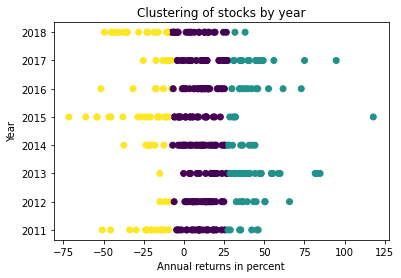

In [43]:
#Scatter plot to show clusters created for each stock every year
stock_df_annual['Year'] = pd.DatetimeIndex(stock_df_annual['Date']).year
plt.scatter(stock_df_annual['annual_returns'], stock_df_annual['Year'], c= clusters)
plt.xlabel('Annual returns in percent')
plt.ylabel('Year')
plt.title('Clustering of stocks by year')
plt.show()

### Ten iterations 

In [44]:
# CLUSTERING: K-Means clustering (random initialization, ten iterations)
clustering = KMeans(n_clusters = 3, init = 'random', n_init = 10).fit(x_scaled_annual)
clusters = clustering.labels_
centers = clustering.cluster_centers_
print(clusters)
print(centers)

[0 1 0 1 0 0 1 0 1 1 1 0 0 2 0 2 0 1 1 1 0 0 0 0 0 1 1 2 1 0 1 1 0 0 1 0 2
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 2 1 1 2 2 1 1 0 1 2 1 1 2 0 0 1 0 0 1 0 2 0
 1 0 0 0 1 2 0 0 0 0 2 1 0 2 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 2 2 0 0 2 1 2
 2 2 0 1 2 2 0 0 2 2 2 2 2 2 1 1 0 0 1 0 2 2 0 1 2 2 1 2 2 0 1 1 1 1 0 1 2
 0 0 1 0 0 0 1 2 0 2 1 0 0 2 2 0 0 2 0 2 1 1 0 0 1 0 0 0 1 0 0 0 0 0 2 1 1
 0 0 1 1 0 0 2 2 0 0 0 0 0 0 0 0 1 0 1 0 2 0 2 0 1 2 0 0 1 0 1 0 0 0 1 0 0
 0 1 2 2 0 2 0 2 0 2 0 0 0 1 0 0 0 0 1 1 0 0 2 2 1 0 2 0 0 1 1 0 0 1 0 2 0
 0 2 2 1 1 2 2 0 1 2 2 1 0 2 0 0 1 0 1 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0
 2 2 0 1 0 2 0 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 2 1 0 1 1
 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0 1 1 0 0 2 0 0 0 0 0 2 0 1 0 2
 0 1 0 2 1 2 2]
[[-0.04111097]
 [ 1.25178785]
 [-1.3501684 ]]


In [45]:
# Compute silhouette coefficient
print(metrics.silhouette_score(x_scaled_annual, clusters, metric = "euclidean"))

0.5508485448287241


In [46]:
#save clusters in the dataframe
stock_df_annual['clusters'] = clusters

<ipython-input-46-d6859ab855df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_annual['clusters'] = clusters


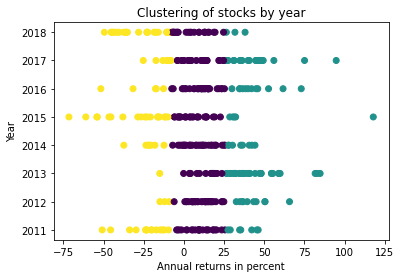

In [47]:
#Scatter plot to show clusters created for each stock every year
plt.scatter(stock_df_annual['annual_returns'],stock_df_annual['Year'], c= clusters)
plt.xlabel('Annual returns in percent')
plt.ylabel('Year')
plt.title('Clustering of stocks by year')
plt.show()

## Agglomerative

### Single linkage

In [48]:
# CLUSTERING: Agglomerative clustering with single (min) linkage and 3 predictors Total population, race, education
clustering = linkage(x_scaled_annual, method = "single", metric = "euclidean")

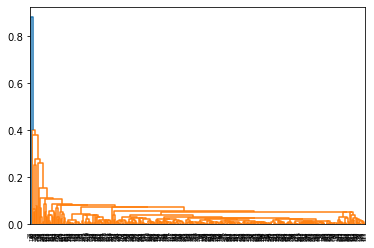

In [49]:
# Plot dendrogram
plt.figure()
dendrogram(clustering)
plt.show()

In [50]:
# Form clusters
clusters = fcluster(clustering, 3, criterion = 'maxclust')

In [51]:
# Compute silhouette coefficient
print(metrics.silhouette_score(x_scaled_annual, clusters, metric = "euclidean"))

0.5500540966404415


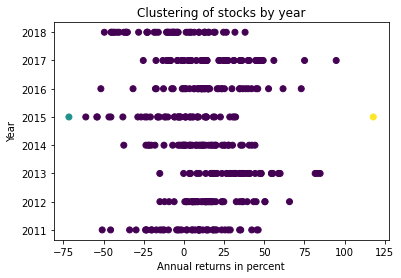

In [52]:
# Plot clusters for every stock by year
plt.scatter(stock_df_annual['annual_returns'],stock_df_annual['Year'], c= clusters)
plt.xlabel('Annual returns in percent')
plt.ylabel('Year')
plt.title('Clustering of stocks by year')
plt.show()

### Complete linkage 

In [53]:
# CLUSTERING: Agglomerative clustering with complete (max) linkage
clustering = linkage(x_scaled_annual, method = "complete", metric = "euclidean")

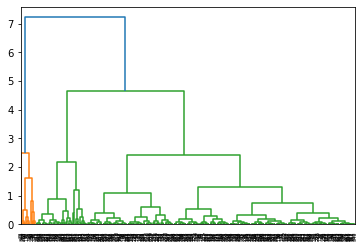

In [54]:
# Plot dendrogram
plt.figure()
dendrogram(clustering)
plt.show()

In [55]:
# Form clusters
clusters = fcluster(clustering, 3, criterion = 'maxclust')
print(clusters)

[3 3 3 3 3 3 3 3 3 3 1 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 1 2 1 3 1 3 3 3 1 3 2
 3 3 3 3 3 1 3 3 3 1 3 3 3 3 3 2 3 1 2 2 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 2 3 3
 2 2 3 3 2 2 3 3 2 2 2 3 2 2 3 3 3 3 3 3 2 2 3 3 2 3 1 3 2 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3
 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 1 3 3
 3 3 2 2 3 2 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3 3 2 3 3 3 3 3 3 3 3 2 3
 3 2 2 1 3 2 2 3 3 2 2 3 3 2 3 3 1 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 3
 2 2 3 3 3 2 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 2 3 3 3 2
 3 1 3 2 1 3 2]


In [56]:
# Compute silhouette coefficient
print(metrics.silhouette_score(x_scaled_annual, clusters, metric = "euclidean"))

0.4695055975885667


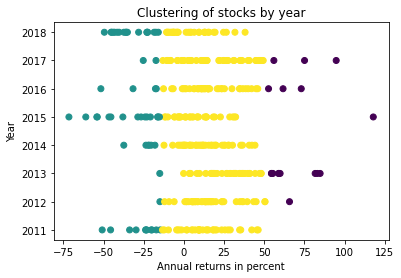

In [57]:
#Scatter plot to show clusters created for each stock every year
plt.scatter(stock_df_annual['annual_returns'],stock_df_annual['Year'], c= clusters)
plt.xlabel('Annual returns in percent')
plt.ylabel('Year')
plt.title('Clustering of stocks by year')
plt.show()

## DBSCAN 

In [58]:
# CLUSTERING: DBSCAN
clustering = DBSCAN(eps = 0.5, min_samples = 150, metric = "euclidean").fit(x_scaled_annual)

In [59]:
# Show clusters
clusters = clustering.labels_
print(clusters)

[ 0 -1  0 -1  0  0 -1  0 -1 -1 -1  0  0 -1  0 -1  0 -1 -1 -1  0  0  0  0
  0 -1 -1 -1 -1  0 -1  0  0  0 -1  0 -1  0 -1  0  0  0 -1  0  0  0 -1  0
  0  0  0  0 -1 -1 -1 -1 -1 -1  0  0 -1  0 -1 -1  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0 -1 -1  0 -1 -1  0 -1 -1 -1  0  0 -1
 -1 -1 -1 -1 -1 -1 -1  0  0 -1  0 -1 -1  0 -1 -1  0 -1  0 -1  0 -1 -1  0
  0  0 -1  0  0  0 -1  0  0  0 -1  0  0 -1  0  0  0  0  0  0  0 -1  0  0
  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0 -1 -1 -1  0  0 -1  0  0  0  0
 -1  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0 -1  0 -1  0  0  0  0  0 -1
  0  0  0 -1  0  0  0 -1 -1 -1  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0
 -1 -1  0  0 -1 -1 -1  0 -1  0  0 -1  0  0  0 -1  0 -1  0  0 -1 -1 -1 -1
 -1 -1  0  0 -1 -1 -1  0 -1  0  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 -1 -1  0 -1 -1  0 -1  0 -1  0 -1 -1  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0

In [60]:
#Compute silhouette coefficient
silhouette_coefficient = metrics.silhouette_score(x_scaled_annual, clusters, metric = "euclidean")
print(silhouette_coefficient)

0.3614600208536709


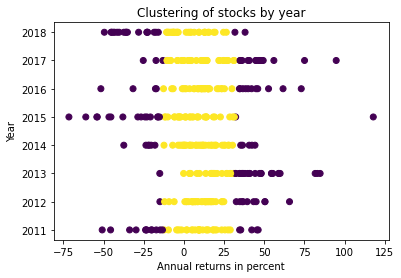

In [61]:
#Scatter plot to show clusters created for each stock every year
plt.scatter(stock_df_annual['annual_returns'],stock_df_annual['Year'], c= clusters)
plt.xlabel('Annual returns in percent')
plt.ylabel('Year')
plt.title('Clustering of stocks by year')
plt.show()

## Clustering based on Average returns of nine years

In [62]:
# Calculate average annual returns of all years grouped by stocks
stock_df_avg = stock_df_annual[['stock', 'annual_returns']].groupby('stock').mean()
stock_df_avg

,annual_returns
stock,
AAPL,19.806512
ADS,15.897381
AMGN,20.462818
AMZN,36.118626
AXP,14.473791
BA,29.001977
CAT,10.337485
CRM,22.739359
CSCO,13.597164


In [63]:
# Standardize all data without splitting into training and validation
# CLUSTERING
scaler = StandardScaler()
scaler.fit(stock_df_avg['annual_returns'].values.reshape(-1,1))
x_scaled_avg = scaler.transform(stock_df_avg['annual_returns'].values.reshape(-1,1) )
x_scaled_avg

array([[ 0.77327473],
       [ 0.48801126],
       [ 0.82116771],
       [ 1.96362871],
       [ 0.38412672],
       [ 1.44430108],
       [ 0.08228552],
       [ 0.98729514],
       [ 0.32015612],
       [-0.05121647],
       [-0.13500999],
       [ 0.57216639],
       [ 0.02448657],
       [-1.31006947],
       [-0.99860358],
       [-3.94318079],
       [-0.2058146 ],
       [-0.58135273],
       [ 1.22970982],
       [ 0.51344026],
       [-1.88992466],
       [-0.6029472 ],
       [ 0.45687146],
       [ 0.30535919],
       [ 0.46965762],
       [-1.3159085 ],
       [-0.08751004],
       [ 0.04306396],
       [ 0.4696096 ],
       [ 0.43696289],
       [-1.23213315],
       [ 0.36947375],
       [-0.56987685],
       [ 0.88807915],
       [-1.22380683],
       [-0.93477321],
       [ 0.772457  ],
       [-0.06859459],
       [-0.99150871],
       [-1.03454151],
       [ 0.17803608],
       [-0.22865808],
       [ 0.29026339],
       [ 1.49893587],
       [ 1.57055641],
       [ 0

In [64]:
# CLUSTERING: K-Means clustering (random initialization, single iterations)
clustering = KMeans(n_clusters = 3, init = 'random', n_init = 10).fit(x_scaled_avg)
clusters = clustering.labels_
centers = clustering.cluster_centers_
print(clusters)
print(centers)

[1 2 1 1 2 1 2 1 2 2 2 2 2 0 0 0 2 2 1 2 0 2 2 2 2 0 2 2 2 2 0 2 2 1 0 0 1
 2 0 0 2 2 2 1 1 2 2 2 2]
[[-1.48744504]
 [ 1.19494056]
 [ 0.10086361]]


In [65]:
stock_df_avg.reset_index(inplace = True)
stock_df_avg

,stock,annual_returns
0,AAPL,19.806512
1,ADS,15.897381
2,AMGN,20.462818
3,AMZN,36.118626
4,AXP,14.473791
5,BA,29.001977
6,CAT,10.337485
7,CRM,22.739359
8,CSCO,13.597164
9,CTSH,8.508029


In [66]:
# Compute adjusted Rand index and silhouette coefficient
#print(metrics.adjusted_rand_score(stock_df['Type'], clusters))
print(metrics.silhouette_score(x_scaled_avg, clusters, metric = "euclidean"))

0.5501965679777925


<ipython-input-67-16f7b9319542>:12: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(stock_df_avg.loc[i,'stock'],(x, y),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), horizontalalignment='right', verticalalignment='top')


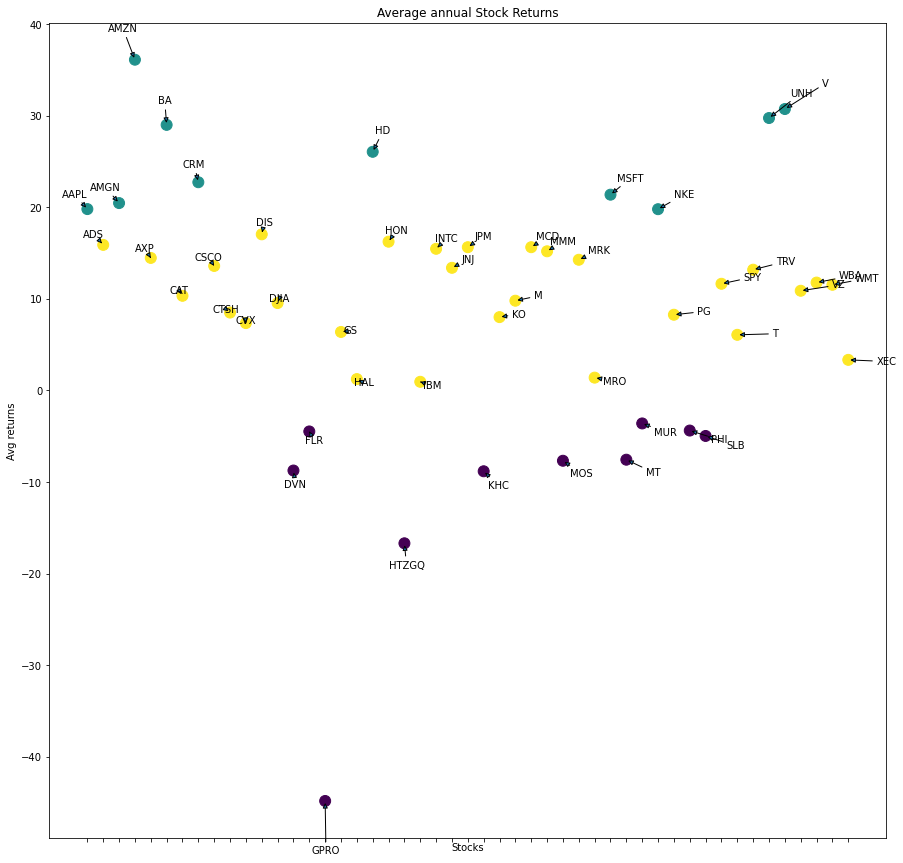

In [67]:
# Plot average returns of all stocks to show high performing, average performing and low performing stocks
fig, ax = plt.subplots(figsize=(15,15))
#plt.figure(figsize=(15,5))
plt.scatter(stock_df_avg['stock'],stock_df_avg['annual_returns'],  c= clusters, s = 120)
plt.title('Average annual Stock Returns')
plt.ylabel('Avg returns')
plt.xlabel('Stocks')
ax.tick_params(labelbottom=False)  
for i, j in enumerate(stock_df_avg['stock']):
    x = i
    y = stock_df_avg.loc[i,'annual_returns']
    plt.annotate(stock_df_avg.loc[i,'stock'],(x, y),textcoords='offset points', arrowprops=dict(arrowstyle='-|>'), horizontalalignment='right', verticalalignment='top')
              
plt.show()